In [1]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
#Auxiliary functions
def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y


def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)

#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)

In [8]:
import numpy as np
import pickle
from sklearn.utils import shuffle

# Number of samples to extract per class for the test set
n_samples_per_class = 400

# Arrays to store the extracted test set and remaining training set
X_test_extracted = []
y_test_extracted = []
X_train_remaining = []
y_train_remaining = []

# Loop through each fault class and split data
for fault_class in range(7):  # Assuming 7 fault classes (0 to 6)
    # Get indices of samples belonging to the current fault class
    class_indices = np.where(y == fault_class)[0]
    class_X = X[class_indices]
    class_y = y[class_indices]

    # Shuffle the samples for randomness
    class_X, class_y = shuffle(class_X, class_y, random_state=42)

    # Extract the last 400 samples for the test set
    X_test_extracted.append(class_X[-n_samples_per_class:])
    y_test_extracted.append(class_y[-n_samples_per_class:])

    # Use the remaining samples for the training set
    X_train_remaining.append(class_X[:-n_samples_per_class])
    y_train_remaining.append(class_y[:-n_samples_per_class])


# Combine the test set samples from all classes
X_test_extracted = np.vstack(X_test_extracted)
y_test_extracted = np.hstack(y_test_extracted)

# Combine the remaining training set samples from all classes
X_train_remaining = np.vstack(X_train_remaining)
y_train_remaining = np.hstack(y_train_remaining)

# Save the test set to a pickle file
test_output_file = "wdt-test.pickle"
with open(test_output_file, "wb") as f:
    pickle.dump({'X': X_test_extracted, 'y': y_test_extracted}, f)
print(f"Test dataset saved to {test_output_file}")

# Save the training set to another pickle file
train_output_file = "wdt-train.pickle"
with open(train_output_file, "wb") as f:
    pickle.dump({'X': X_train_remaining, 'y': y_train_remaining}, f)
print(f"Training dataset saved to {train_output_file}")

Test dataset saved to wdt-test.pickle
Training dataset saved to wdt-train.pickle


In [5]:
# Check for overlap between training and test sets
train_hashes = {hash(tuple(row)) for row in X_train_remaining}
test_hashes = {hash(tuple(row)) for row in X_test_extracted}
overlap = train_hashes & test_hashes
print(f"Number of overlapping samples: {len(overlap)}")
if len(overlap) > 0:
    print("Data leakage detected! Overlapping samples exist between training and test sets.")
else:
    print("No overlap between training and test sets.")


Number of overlapping samples: 0
No overlap between training and test sets.


In [52]:
#Import packages

import numpy as np
from numpy.typing import NDArray
import pickle
import matplotlib.pyplot as plt
from sklearn.linear_model import LogisticRegression
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
import numpy as np
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import accuracy_score
from sklearn.utils import shuffle
#Auxiliary functions

def onehot2cat(y:NDArray) -> NDArray:
    '''Convert y in one_hot to categorical'''
    return np.argmax(y, axis=1) 


def loadDataset(fn:str, toCat:bool=False) -> NDArray:
    '''load dataset'''
    with open(fn, 'rb') as f:
        data = pickle.load(f)
        
    X = data['X'] 
    if toCat: y = onehot2cat(data['Y'])
    else:     y = data['Y'] 
    
    return X, y


def saveSKLModel(fn:str, model) -> None:
    '''save SKLearn model as pickle'''
    with open(fn, 'wb') as f:
        pickle.dump(model, f)

#load dataset

fnt = 'wtdt-part.pickle'
X, y = loadDataset(fnt, toCat=True)
#X, y = shuffle(X, y, random_state=42)

class_weights = {0: 1.0, 1: 1.0, 2: 1.0, 3: 1.0, 4: 1.0, 5: 1.0, 6: 1.0}
model = RandomForestClassifier(class_weight=class_weights)
model.fit(X,y)

saveSKLModel("T1-randomForest.pickle", model)


In [60]:
from sklearn.utils import shuffle
from sklearn.metrics import accuracy_score

# Number of samples to remove for testing per class
n_test_samples_per_class = 500  # Adjust based on your dataset size and needs

# Create test set and train set with even distribution across classes
X_train_balanced, y_train_balanced = [], []
X_test_balanced, y_test_balanced = [], []

# Loop through each fault class and split data
for fault_class in range(7):  # Assuming 7 fault classes
    class_indices = np.where(y == fault_class)[0]  # Find indices of this class
    class_X = X[class_indices]
    class_y = y[class_indices]

    # Shuffle the class-specific data
    class_X, class_y = shuffle(class_X, class_y, random_state=42)

    # Split into test and training subsets
    X_test_balanced.append(class_X[:n_test_samples_per_class])
    y_test_balanced.append(class_y[:n_test_samples_per_class])

    X_train_balanced.append(class_X[n_test_samples_per_class:])
    y_train_balanced.append(class_y[n_test_samples_per_class:])

# Combine all classes
X_train_balanced = np.vstack(X_train_balanced)
y_train_balanced = np.hstack(y_train_balanced)

X_test_balanced = np.vstack(X_test_balanced)
y_test_balanced = np.hstack(y_test_balanced)

# Shuffle the training and test sets
X_train_balanced, y_train_balanced = shuffle(X_train_balanced, y_train_balanced, random_state=42)
X_test_balanced, y_test_balanced = shuffle(X_test_balanced, y_test_balanced, random_state=42)

# Train the model on the balanced training set
model = RandomForestClassifier(class_weight='balanced', random_state=42)
model.fit(X_train_balanced, y_train_balanced)

# Predict on the balanced test set
y_pred_balanced = model.predict(X_test_balanced)

# Overall accuracy
overall_accuracy = accuracy_score(y_test_balanced, y_pred_balanced)
print(f"Overall Test Accuracy: {overall_accuracy:.4f}")

# Accuracy for each fault class
for fault_class in range(7):
    class_indices = np.where(y_test_balanced == fault_class)[0]
    y_class_true = y_test_balanced[class_indices]
    y_class_pred = y_pred_balanced[class_indices]
    class_accuracy = accuracy_score(y_class_true, y_class_pred)
    print(f"Accuracy for Fault Class {fault_class}: {class_accuracy:.4f}")




Overall Test Accuracy: 0.9994
Accuracy for Fault Class 0: 1.0000
Accuracy for Fault Class 1: 1.0000
Accuracy for Fault Class 2: 1.0000
Accuracy for Fault Class 3: 1.0000
Accuracy for Fault Class 4: 0.9980
Accuracy for Fault Class 5: 0.9980
Accuracy for Fault Class 6: 1.0000


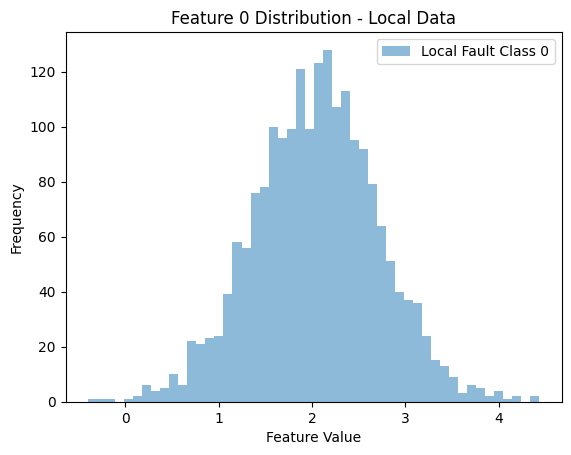

In [59]:
import matplotlib.pyplot as plt

# Compare feature 0 distributions for fault class 0
plt.hist(X[y == 0, 0], bins=50, alpha=0.5, label='Local Fault Class 0')
plt.title("Feature 0 Distribution - Local Data")
plt.xlabel("Feature Value")
plt.ylabel("Frequency")
plt.legend()
plt.show()

# Simulate the same plot for server data if possible
# Replace `X_server` and `y_server` with server data arrays, if accessible
# plt.hist(X_server[y_server == 0, 0], bins=50, alpha=0.5, label='Server Fault Class 0')
# 

# Simulate the professor´s ordered data-set

In [23]:
# Split data without shuffling
n_classes = 7
samples_per_class = 2000
total_samples = samples_per_class * n_classes

# Simulate a "validation-like" ordered test set
X_ordered_test = X[::10, :]  # e.g., every 5th sample to create stratified ordering
y_ordered_test = y[::10]

# Remaining samples are for training
X_ordered_train = np.delete(X, np.arange(0, total_samples, 5), axis=0)
y_ordered_train = np.delete(y, np.arange(0, total_samples, 5), axis=0)


#### I removed some data from my X and y and will keep it ordered in order to simulate the competition

# Use Stratified K-Fold Validation

In [24]:
from sklearn.model_selection import StratifiedKFold
from sklearn.metrics import accuracy_score

skf = StratifiedKFold(n_splits=5)
model = RandomForestClassifier()
accuracies = []

for train_index, test_index in skf.split(X_ordered_train, y_ordered_train):
    X_train, X_test = X_ordered_train[train_index], X_ordered_train[test_index]
    y_train, y_test = y_ordered_train[train_index], y_ordered_train[test_index]

    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    accuracies.append(accuracy_score(y_test, y_pred))

print(f"Stratified K-Fold Accuracies: {accuracies}")
print(f"Mean Accuracy: {np.mean(accuracies)}")


Stratified K-Fold Accuracies: [0.9977678571428571, 0.9995535714285714, 0.9995535714285714, 0.9986607142857142, 0.9991071428571429]
Mean Accuracy: 0.9989285714285714


# Perform real world-like validation

In [25]:


y_ordered_pred = model.predict(X_ordered_test)
sequential_accuracy = accuracy_score(y_ordered_test, y_seq_pred)
print(f"Sequential Test Accuracy: {sequential_accuracy}")


ValueError: Found input variables with inconsistent numbers of samples: [1400, 2800]

# Analysis

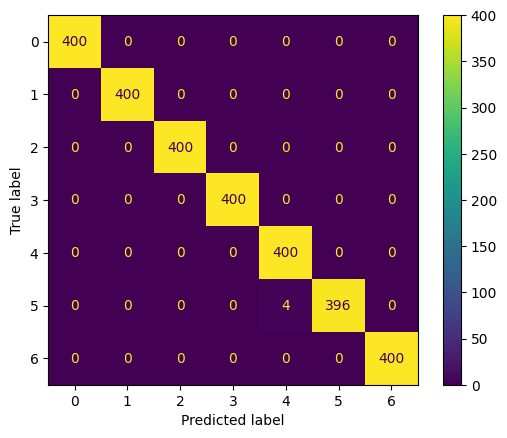

In [21]:
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay

cm = confusion_matrix(y_ordered_test, y_ordered_pred)
ConfusionMatrixDisplay(cm).plot()


In [41]:
start_index = 0
end_index = 2000
X_class_1 = X[start_index:end_index]
y_class_1 = y[start_index:end_index]

# Split into training and test sets (keeping only fault class 1)
X_train_1, X_test_1, y_train_1, y_test_1 = train_test_split(X_class_1, y_class_1, test_size=0.2, random_state=42)

# Train a model (e.g., Random Forest) on fault class 1
model_class_1 = RandomForestClassifier(random_state=42)
model_class_1.fit(X_train_1, y_train_1)

# Evaluate the model on the test set for fault class 1
y_test_1_pred = model_class_1.predict(X_test_1)
accuracy_class_1 = accuracy_score(y_test_1, y_test_1_pred)

print(f"Accuracy on fault class 1: {accuracy_class_1:.4f}")

saveSKLModel("T1-randomForest.pickle", model_class_1)


Accuracy on fault class 1: 1.0000
